In [20]:
import numpy as np
import os,sys


sys.path.append('../..')
sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects_new/MarsLanding_6dof_v7/Run/Run_4km_terminal


In [21]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

6dof dynamics model
Quaternion_attitude
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Reward_terminal
queue fixed
Flat Constraint
Attitude Constraint


<IPython.core.display.Javascript object>


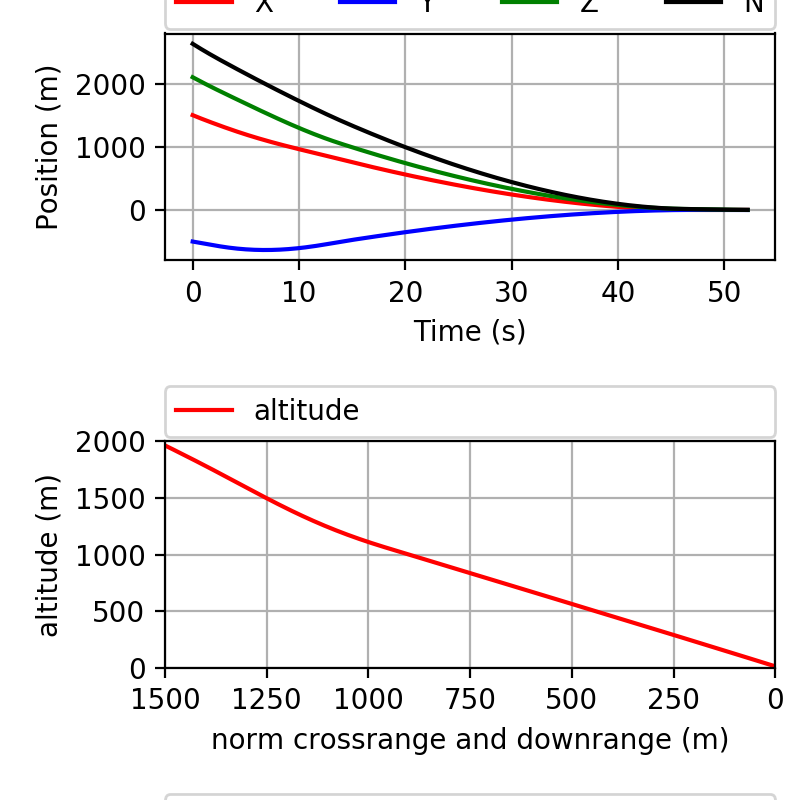

<IPython.core.display.Javascript object>


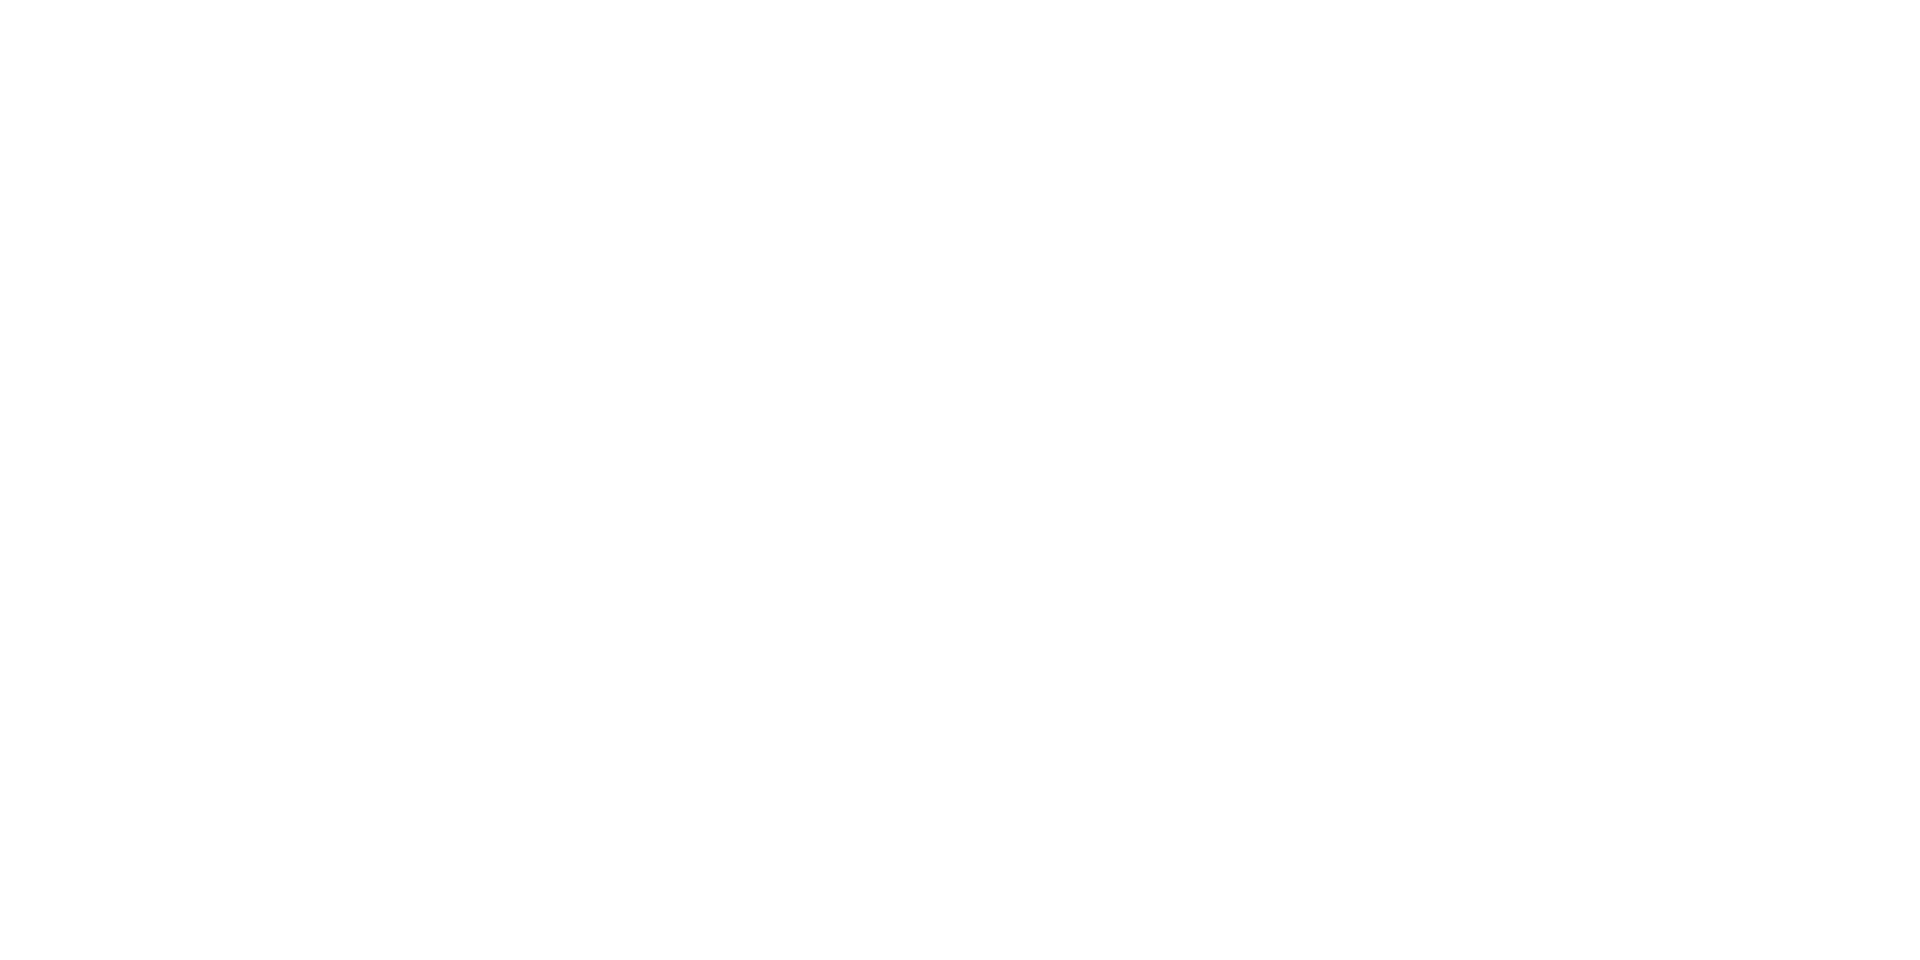

<IPython.core.display.Javascript object>


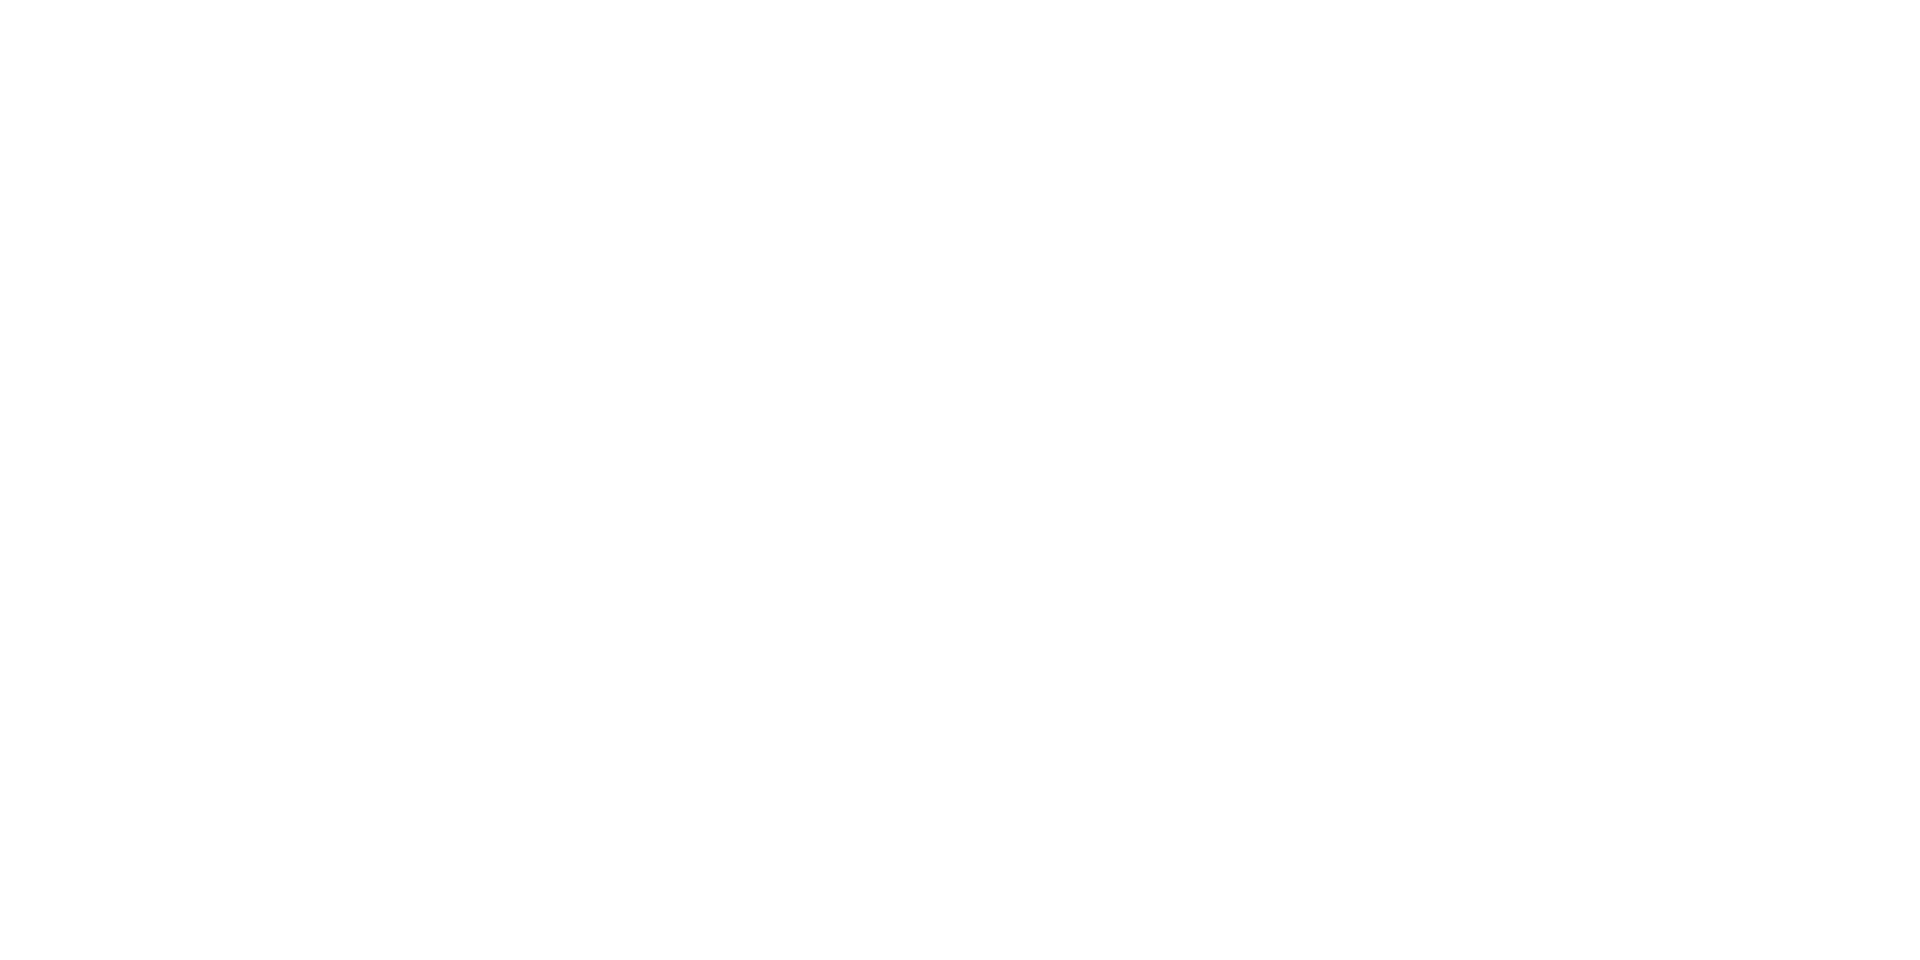

<IPython.core.display.Javascript object>


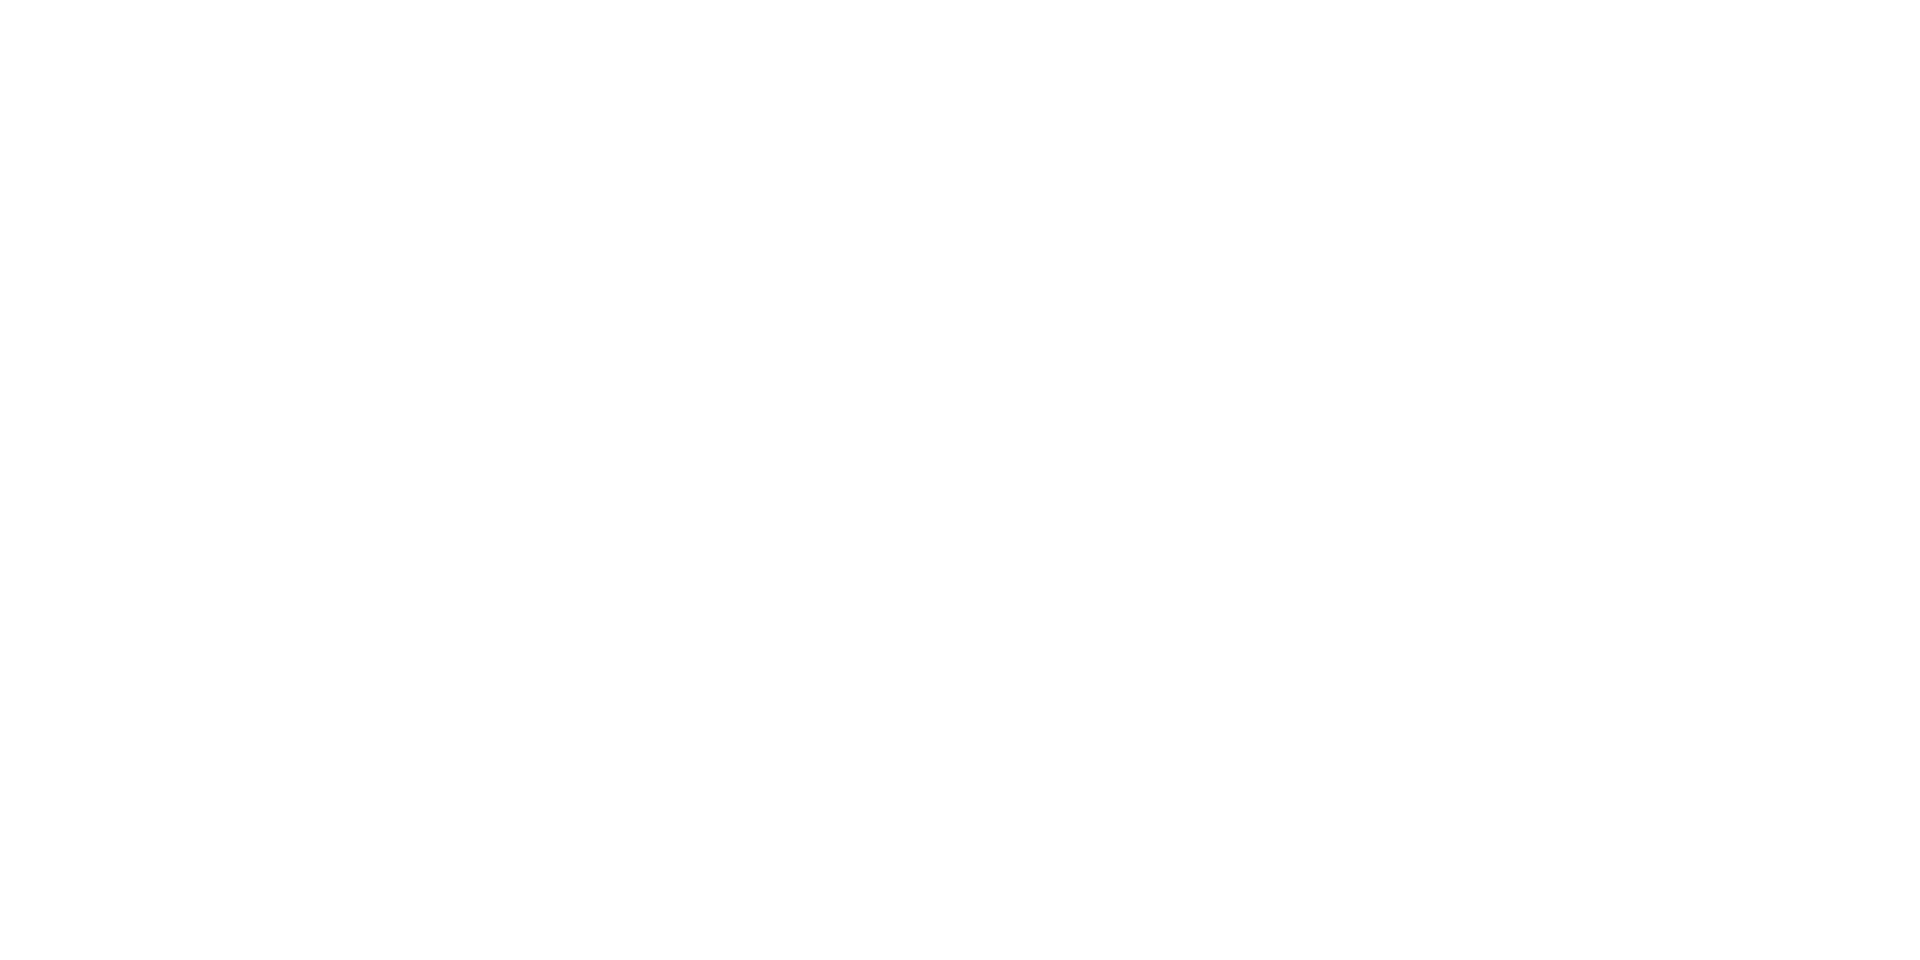

<IPython.core.display.Javascript object>


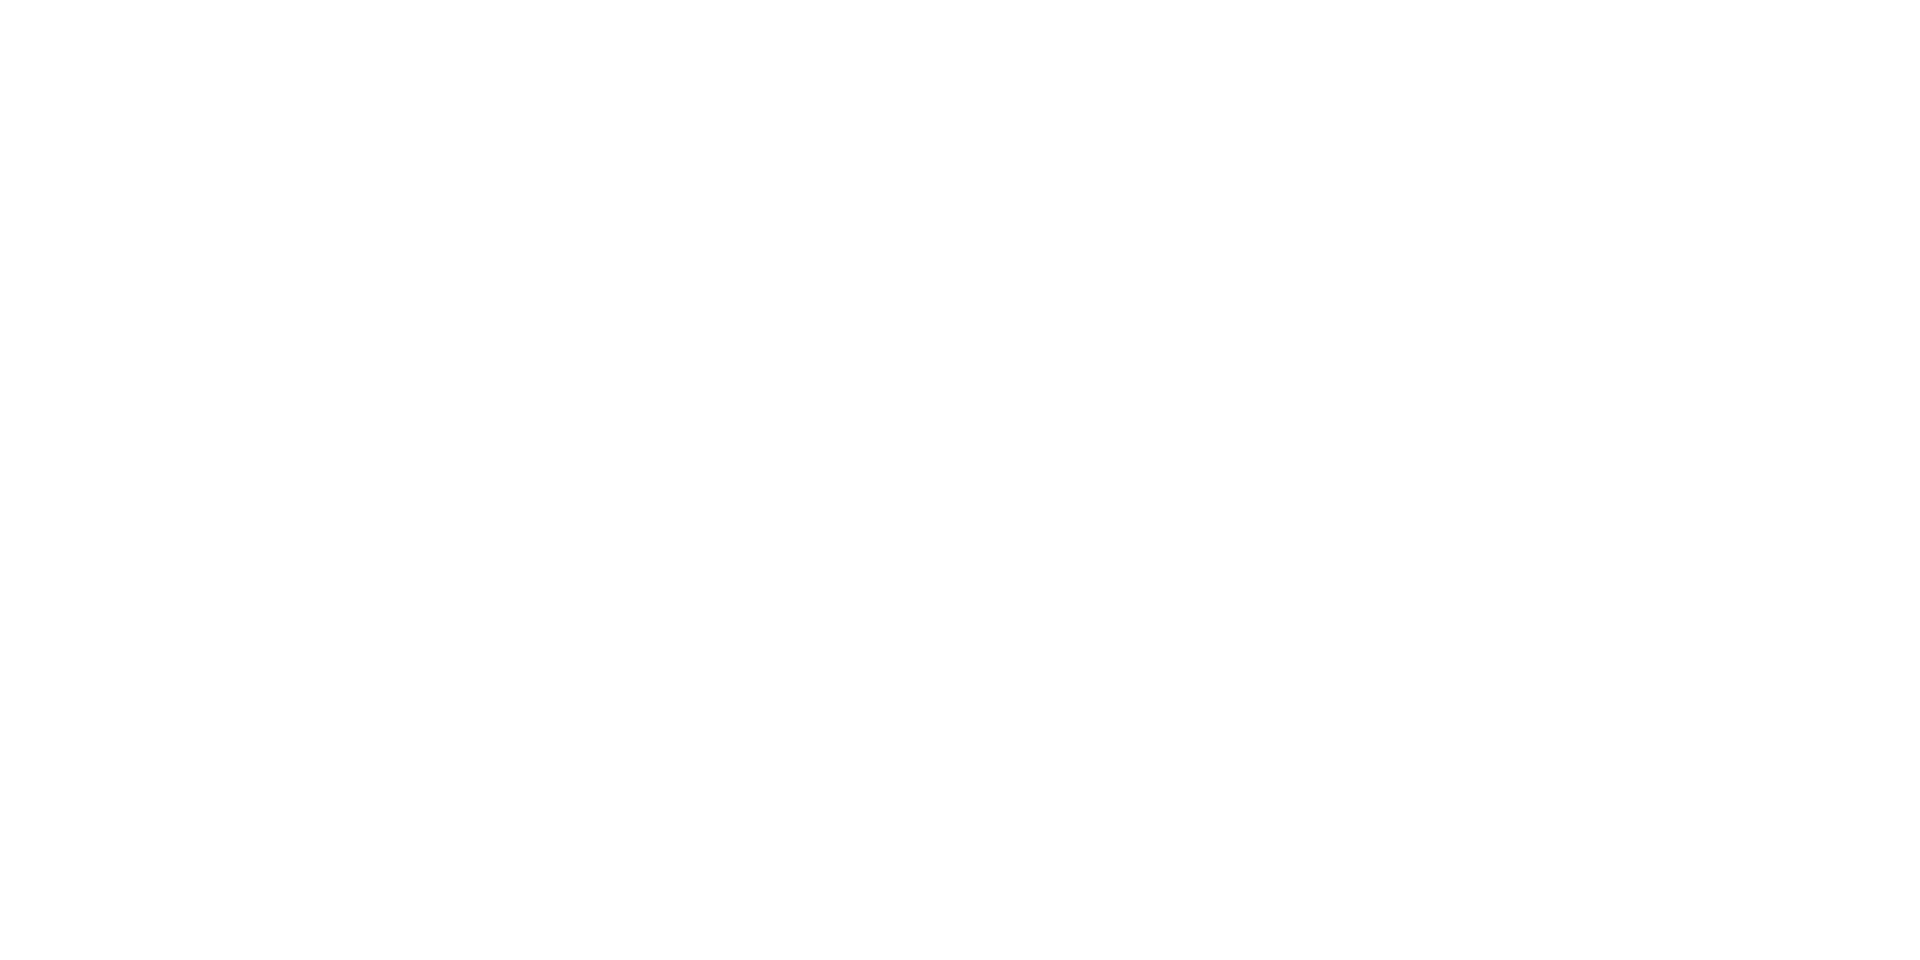

<IPython.core.display.Javascript object>


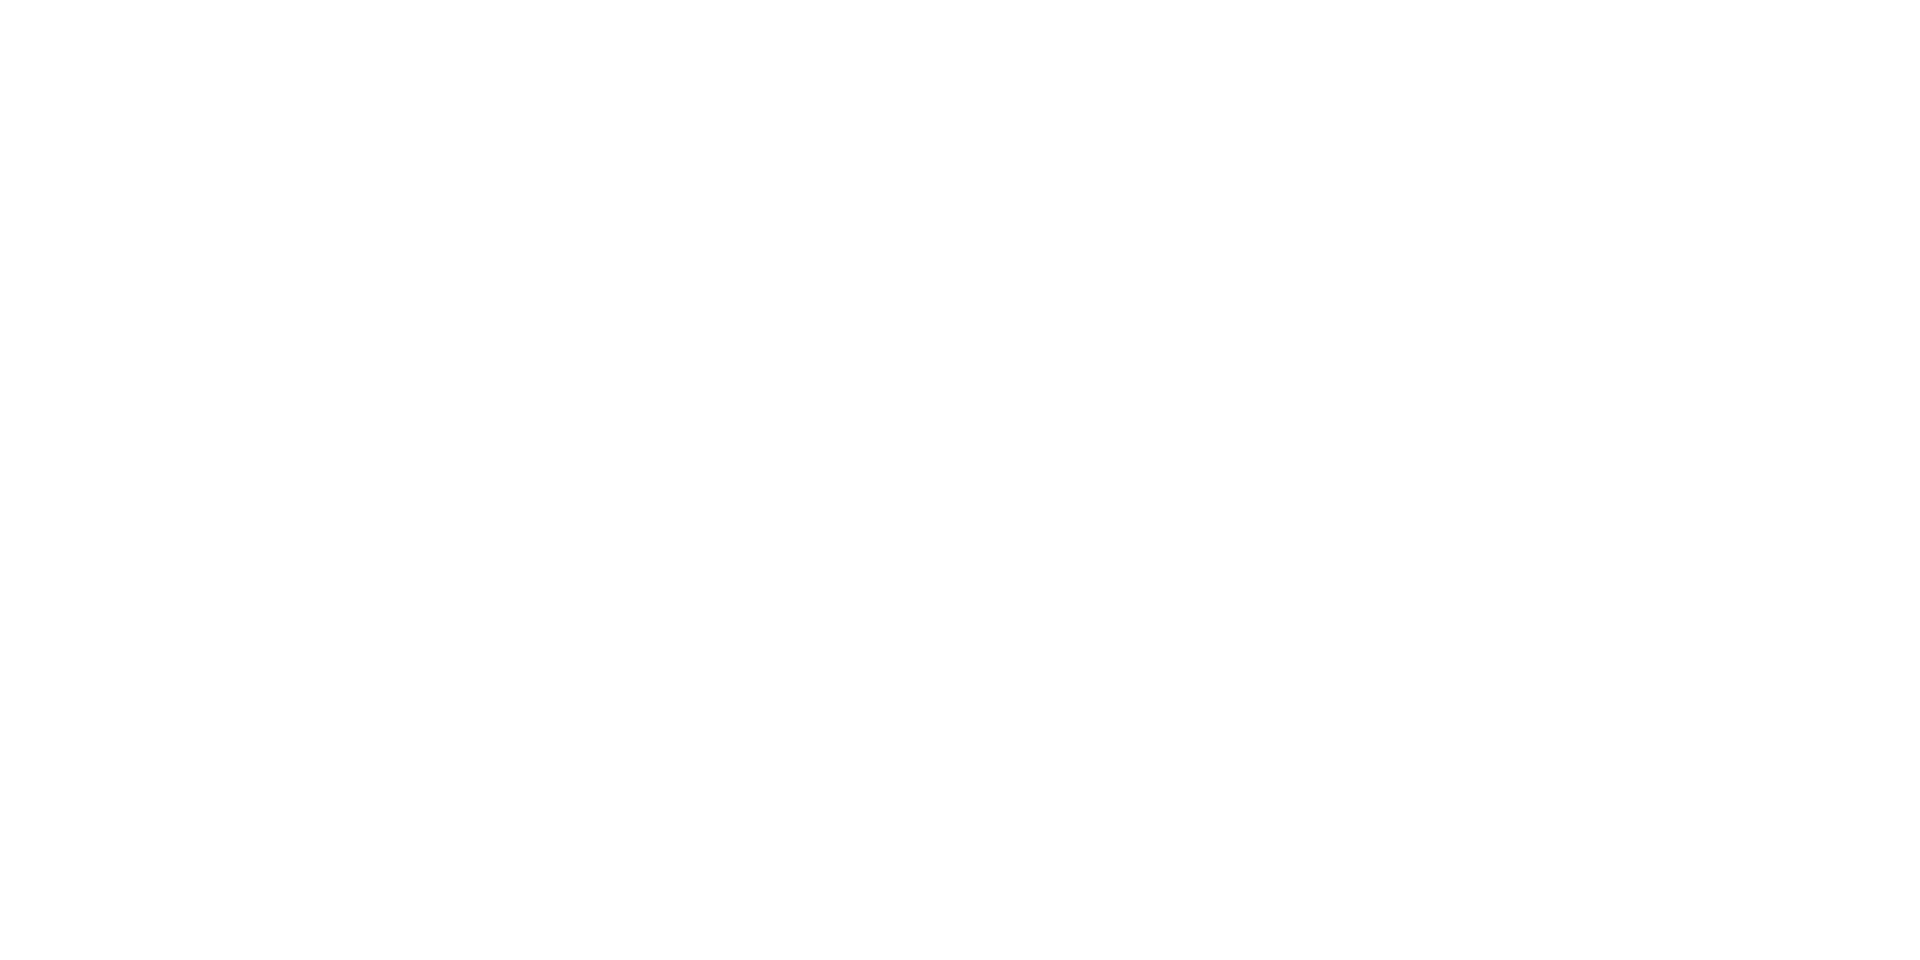

<IPython.core.display.Javascript object>


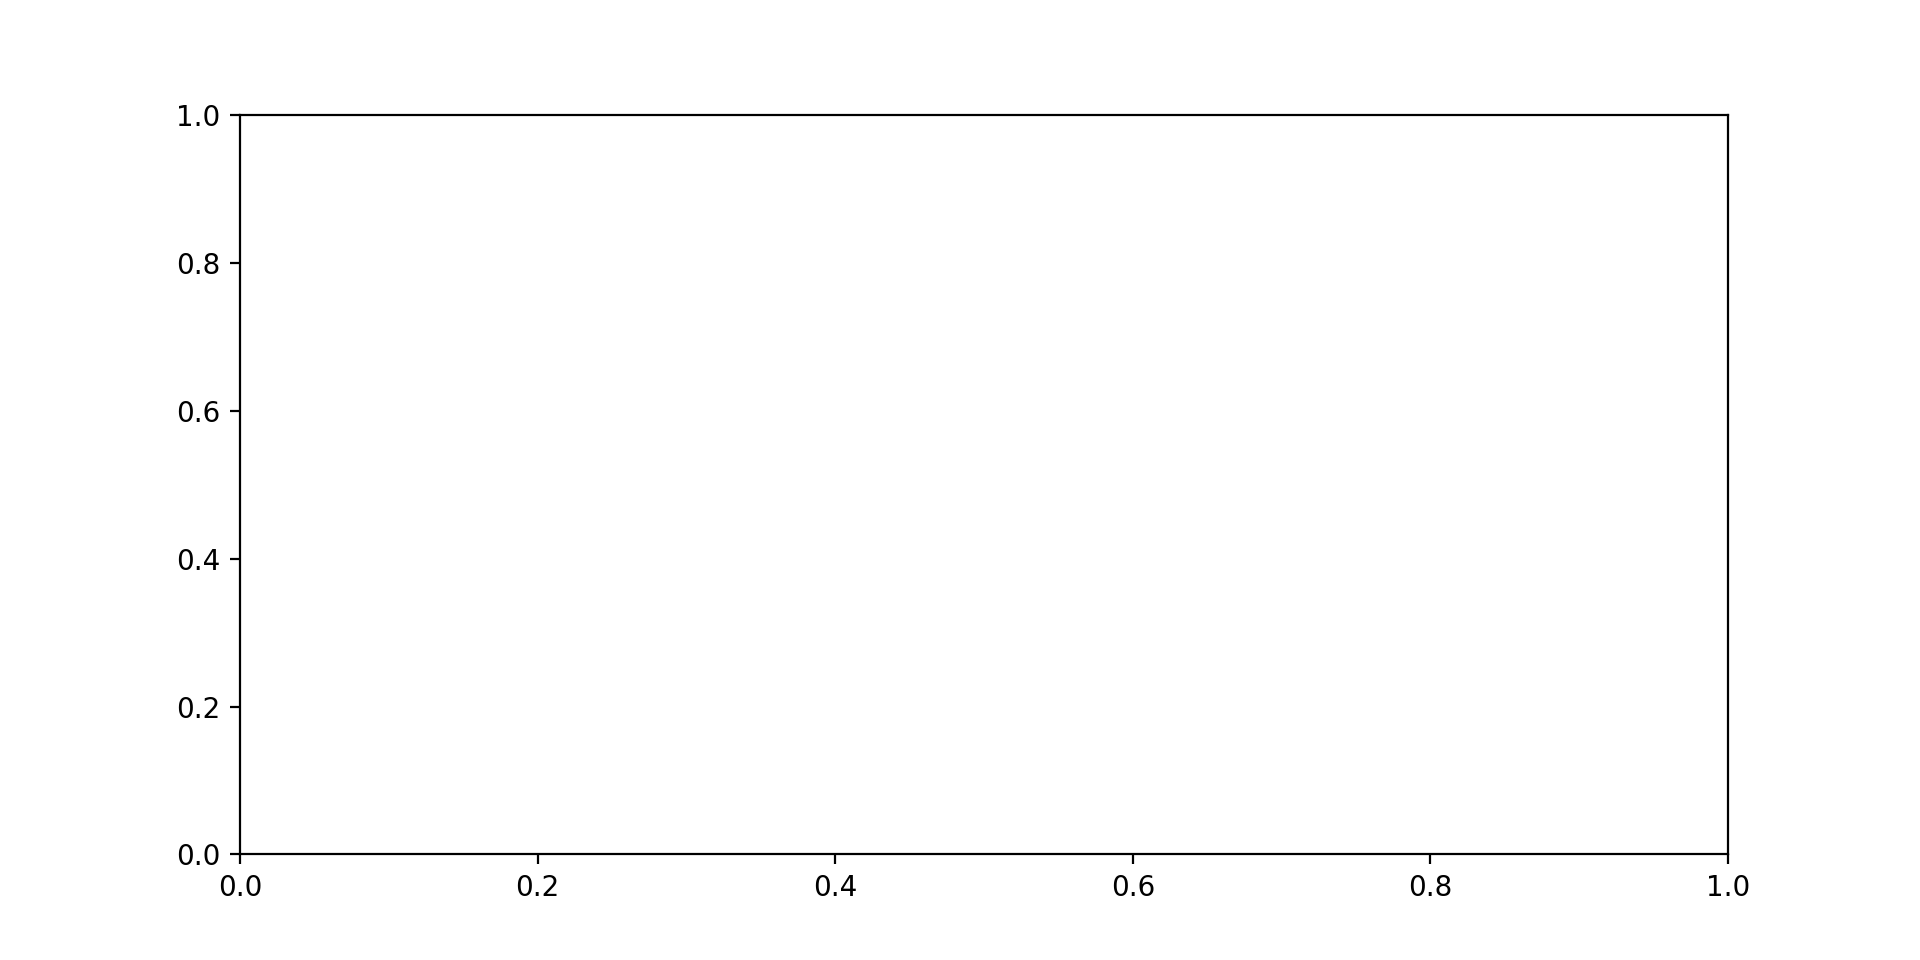

lander env att 2 fixed
PPO Policy 1
Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8
[[-1.]
 [ 0.]
 [ 1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['h1/kernel:0', 'h2/kernel:0', 'h3/bias:0', 'means/bias:0', 'h1/bias:0', 'means/kernel:0', 'logvars:0', 'h2/bias:0', 'h3/kernel:0'])


In [22]:
from env_mdr import Env
from reward_terminal_mdr  import Reward
import env_utils as envu
import attitude_utils as attu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
from agent_mdr2 import Agent
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from attitude_constraint import Attitude_constraint
from thruster_model import Thruster_model

logger = Logger()
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Quaternion_attitude()


lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=15., apf_tau2=100.)
lander_model.get_state_agent = lander_model.get_state_agent_tgo_alt

reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, fuel_coeff=-0.05, debug=False, landing_coeff=10.)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10,
                                         attitude_limit=(10*np.pi, np.pi/2-np.pi/16, np.pi/2-np.pi/16))
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=120.0,print_every=10)




obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True)
import utils
fname = "small_reward-Copy1"
input_normalizer = utils.load_run(policy,fname)
print(input_normalizer)

In [7]:
policy.close_sess()
value_function.close_sess()

NameError: name 'value_function' is not defined

In [7]:
import utils
fname = "small_reward-Copy1"
#utils.save_run(policy,input_normalizer,fname)
utils.save_run(policy,input_normalizer,env.rl_stats.history,fname)

Saved Vars:  ['h1/kernel:0', 'h1/bias:0', 'h2/kernel:0', 'h2/bias:0', 'h3/kernel:0', 'h3/bias:0', 'means/kernel:0', 'means/bias:0', 'logvars:0']


In [6]:
print(input_normalizer)

None


# Test Policy with Realistic Noise
## we slightly relax glideslope constraint

In [10]:
policy.test_mode=True
env.glideslope_constraint.gs_limit=0.00
env.lander=lander_model
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (1900,2100,-90,-70),
                           yaw   = (-np.pi/16, np.pi/16, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/16, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/16, np.pi/16, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=50*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10224.64 |2754.11 |3200.00 |16000.00 |    27
glideslope | 3.922 | 8.147 | 0.700 |572.404 |    49
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -1.0    -1.5    -0.0 |     1.7     0.9    -0.0
velocity |   0.047  -0.026  -0.956 |   0.021   0.063   0.045 |  -0.003  -0.135  -1.079 |   0.098   0.163  -0.830
fuel     |273.10 | 13.84 |247.61 |316.71
attitude_321 |  -0.033  -0.027  -0.016 |   0.127   0.012   0.021 |  -0.320  -0.067  -0.060 |   0.229   0.009   0.044
w        |  -0.036  -0.010  -0.000 |   0.052   0.022   0.000 |  -0.143  -0.128  -0.000 |   0.105   0.047   0.000
glideslope |  20.790 |   8.087 |  10.467 |  57.920
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |10113.51 |2774.38 |3200.00 |16000.00 |    27
glideslope | 3.684 | 8.803 | 0.086 |730.645 |   180
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Fin

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |10103.01 |2783.28 |3200.00 |16000.00 |   424
glideslope | 3.494 | 8.603 | 0.086 |1411.484 |   357
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -1.2    -2.8    -0.0 |     3.4     2.7    -0.0
velocity |   0.045  -0.019  -0.953 |   0.023   0.061   0.043 |  -0.035  -0.146  -1.079 |   0.108   0.174  -0.800
fuel     |276.23 | 15.51 |245.22 |349.17
attitude_321 |  -0.056  -0.026  -0.016 |   0.131   0.011   0.023 |  -0.415  -0.067  -0.075 |   0.392   0.018   0.055
w        |  -0.028  -0.009  -0.000 |   0.051   0.024   0.000 |  -0.174  -0.134  -0.000 |   0.105   0.072   0.000
glideslope |  20.409 |   8.738 |  10.090 | 112.229
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |10098.30 |2785.46 |3200.00 |16000.00 |   424
glideslope | 3.501 | 8.503 | 0.086 |1411.484 |   357
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |10079.13 |2778.62 |3200.00 |16000.00 |   424
glideslope | 3.540 | 9.103 | 0.086 |1587.494 |  1653
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0    -2.8    -0.0 |     3.4     3.7    -0.0
velocity |   0.045  -0.019  -0.951 |   0.023   0.061   0.043 |  -0.035  -0.149  -1.084 |   0.110   0.180  -0.780
fuel     |276.48 | 15.72 |244.02 |349.17
attitude_321 |  -0.056  -0.026  -0.016 |   0.131   0.011   0.022 |  -0.415  -0.067  -0.077 |   0.392   0.018   0.064
w        |  -0.028  -0.009  -0.000 |   0.051   0.023   0.000 |  -0.174  -0.134  -0.000 |   0.105   0.072   0.000
glideslope |  20.189 |   8.492 |   9.590 | 130.422
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |10078.43 |2776.90 |3200.00 |16000.00 |   424
glideslope | 3.544 | 9.034 | 0.086 |1587.494 |  1653
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |10087.37 |2781.22 |3200.00 |16000.00 |  2415
glideslope | 3.573 | 9.707 | 0.086 |3447.291 |  3359
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0    -2.8    -0.0 |     3.4     3.7    -0.0
velocity |   0.046  -0.020  -0.952 |   0.022   0.060   0.043 |  -0.035  -0.149  -1.084 |   0.110   0.184  -0.780
fuel     |276.52 | 15.77 |244.02 |349.17
attitude_321 |  -0.056  -0.026  -0.017 |   0.128   0.011   0.022 |  -0.430  -0.067  -0.077 |   0.392   0.018   0.064
w        |  -0.028  -0.009  -0.000 |   0.051   0.023   0.000 |  -0.180  -0.174  -0.000 |   0.105   0.072   0.000
glideslope |  20.227 |   9.240 |   9.590 | 173.227
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |10085.99 |2780.40 |3200.00 |16000.00 |  2415
glideslope | 3.575 | 9.663 | 0.086 |3447.291 |  3359
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |10077.87 |2776.34 |3200.00 |16000.00 |  2415
glideslope | 3.568 | 9.312 | 0.086 |3447.291 |  3359
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0    -2.8    -0.0 |     3.4     3.7    -0.0
velocity |   0.046  -0.021  -0.952 |   0.023   0.059   0.043 |  -0.035  -0.149  -1.084 |   0.110   0.184  -0.780
fuel     |276.47 | 15.86 |244.02 |350.31
attitude_321 |  -0.055  -0.027  -0.017 |   0.128   0.011   0.022 |  -0.430  -0.067  -0.077 |   0.480   0.018   0.064
w        |  -0.029  -0.009  -0.000 |   0.050   0.023   0.000 |  -0.180  -0.174  -0.000 |   0.105   0.072   0.000
glideslope |  20.163 |   8.996 |   9.459 | 173.227
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |10075.95 |2776.13 |3200.00 |16000.00 |  2415
glideslope | 3.564 | 9.497 | 0.086 |3447.291 |  3359
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |10078.31 |2775.36 |3200.00 |16000.00 |  2415
glideslope | 3.554 |10.037 | 0.086 |4311.915 |  5565
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0    -2.8    -0.0 |     3.4     3.7    -0.0
velocity |   0.046  -0.020  -0.953 |   0.023   0.059   0.043 |  -0.035  -0.151  -1.084 |   0.110   0.184  -0.780
fuel     |276.47 | 15.85 |244.02 |350.31
attitude_321 |  -0.056  -0.027  -0.017 |   0.128   0.011   0.022 |  -0.430  -0.069  -0.077 |   0.480   0.025   0.064
w        |  -0.029  -0.010  -0.000 |   0.050   0.023   0.000 |  -0.180  -0.174  -0.000 |   0.110   0.072   0.000
glideslope |  20.256 |   9.089 |   9.459 | 173.227
i :  5700
Cumulative Stats (mean,std,max,argmax)
thrust   |10078.93 |2775.31 |3200.00 |16000.00 |  2415
glideslope | 3.552 |10.001 | 0.086 |4311.915 |  5565
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |10080.88 |2773.84 |3200.00 |16000.00 |  2415
glideslope | 3.547 | 9.825 | 0.086 |4311.915 |  5565
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0    -2.8    -0.0 |     3.4     3.7    -0.0
velocity |   0.046  -0.020  -0.953 |   0.023   0.059   0.042 |  -0.035  -0.174  -1.084 |   0.110   0.184  -0.769
fuel     |276.43 | 15.90 |244.02 |350.31
attitude_321 |  -0.056  -0.027  -0.017 |   0.128   0.011   0.022 |  -0.430  -0.077  -0.077 |   0.480   0.025   0.064
w        |  -0.029  -0.010  -0.000 |   0.050   0.023   0.000 |  -0.180  -0.174  -0.000 |   0.110   0.072   0.000
glideslope |  20.252 |   8.982 |   9.459 | 173.227
i :  6800
Cumulative Stats (mean,std,max,argmax)
thrust   |10080.99 |2774.10 |3200.00 |16000.00 |  2415
glideslope | 3.546 | 9.808 | 0.086 |4311.915 |  5565
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |10081.01 |2773.59 |3200.00 |16000.00 |  2415
glideslope | 3.531 | 9.682 | 0.060 |4311.915 |  5565
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0   -12.4    -0.0 |     3.4     3.7    -0.0
velocity |   0.046  -0.020  -0.953 |   0.023   0.059   0.042 |  -0.035  -0.174  -1.084 |   0.120   0.184  -0.769
fuel     |276.42 | 15.86 |244.02 |350.31
attitude_321 |  -0.056  -0.027  -0.017 |   0.128   0.011   0.022 |  -0.430  -0.077  -0.079 |   0.480   0.025   0.145
w        |  -0.029  -0.010  -0.000 |   0.050   0.024   0.000 |  -0.180  -0.174  -0.000 |   0.110   0.072   0.000
glideslope |  20.353 |   9.834 |   3.841 | 301.725
i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |10081.35 |2773.33 |3200.00 |16000.00 |  2415
glideslope | 3.533 | 9.650 | 0.060 |4311.915 |  5565
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |10081.12 |2771.92 |3200.00 |16000.00 |  2415
glideslope | 3.543 | 9.523 | 0.060 |4311.915 |  5565
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0   -12.4    -0.0 |     3.4     3.7    -0.0
velocity |   0.046  -0.021  -0.953 |   0.023   0.059   0.042 |  -0.037  -0.174  -1.084 |   0.120   0.184  -0.769
fuel     |276.40 | 15.82 |244.02 |350.31
attitude_321 |  -0.056  -0.027  -0.017 |   0.127   0.011   0.022 |  -0.430  -0.077  -0.079 |   0.480   0.034   0.145
w        |  -0.029  -0.010  -0.000 |   0.050   0.024   0.000 |  -0.180  -0.174  -0.000 |   0.110   0.072   0.000
glideslope |  20.359 |  10.219 |   3.841 | 310.290
i :  9000
Cumulative Stats (mean,std,max,argmax)
thrust   |10080.04 |2771.69 |3200.00 |16000.00 |  2415
glideslope | 3.543 | 9.507 | 0.060 |4311.915 |  5565
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0



Cumulative Stats (mean,std,max,argmax)
thrust   |10077.46 |2770.76 |3200.00 |16000.00 |  2415
glideslope | 3.529 | 9.692 | 0.060 |4311.915 |  5565
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0   -12.4    -0.0 |     3.4     3.7    -0.0
velocity |   0.046  -0.021  -0.953 |   0.023   0.059   0.042 |  -0.037  -0.174  -1.084 |   0.120   0.184  -0.769
fuel     |276.46 | 15.82 |244.02 |350.31
attitude_321 |  -0.056  -0.027  -0.017 |   0.127   0.011   0.022 |  -0.430  -0.077  -0.088 |   0.480   0.034   0.145
w        |  -0.029  -0.010  -0.000 |   0.050   0.024   0.000 |  -0.194  -0.174  -0.000 |   0.110   0.072   0.000
glideslope |  20.352 |  10.011 |   3.841 | 310.290

Initial Stats (mean,std,min,max)
position |  1002.7     8.7  1999.0 |   581.2   575.3    57.8 |     0.1  -999.9  1900.0 |  1999.3   999.5  2100.0
velocity | -40.149   0.137 -79.975 |  17.322  17.306   5.762 | -70.000 -

# 9 square km

In [34]:
policy.test_mode=True
env.lander.divert=(0,0,0)
env.lander.apf_pot=env.lander.apf_pot2
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,3000 , -70, -10), 
                           crossrange = (-1500,1500 , -30,30),  
                           altitude = (2400,2500,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=0*np.ones(3), noise_sd=0*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9573.89 |2625.48 |3200.00 |16000.00 |    11
glideslope | 3.085 |12.029 | 0.455 |1108.913 |    52
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -1.5    -1.3    -0.0 |     1.9     1.3    -0.0
velocity |   0.042  -0.024  -0.947 |   0.016   0.068   0.044 |  -0.007  -0.155  -1.027 |   0.088   0.165  -0.802
fuel     |311.09 | 23.06 |270.77 |377.46
attitude_321 |  -0.054  -0.026  -0.018 |   0.171   0.010   0.020 |  -0.420  -0.063  -0.078 |   0.433  -0.004   0.034
w        |  -0.021  -0.006  -0.000 |   0.052   0.023   0.000 |  -0.144  -0.089  -0.000 |   0.099   0.059   0.000
glideslope |  20.110 |   6.161 |  11.183 |  42.113
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9574.74 |2641.16 |3200.00 |16000.00 |   136
glideslope | 3.023 |10.405 | 0.455 |1108.913 |    52
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Fin

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9609.55 |2627.92 |3200.00 |16000.00 |   666
glideslope | 3.214 |10.744 | 0.436 |1423.673 |   375
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -1.7    -2.3    -0.0 |     2.1     2.0    -0.0
velocity |   0.042  -0.028  -0.942 |   0.016   0.069   0.047 |  -0.028  -0.161  -1.063 |   0.131   0.190  -0.760
fuel     |309.17 | 22.98 |266.30 |391.04
attitude_321 |  -0.062  -0.026  -0.018 |   0.165   0.009   0.022 |  -0.450  -0.067  -0.083 |   0.433   0.012   0.047
w        |  -0.028  -0.008  -0.000 |   0.055   0.026   0.000 |  -0.186  -0.133  -0.000 |   0.111   0.077   0.000
glideslope |  20.827 |   9.615 |   9.754 | 222.775
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |9609.63 |2628.69 |3200.00 |16000.00 |   666
glideslope | 3.188 |10.547 | 0.436 |1423.673 |   375
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9603.75 |2631.93 |3200.00 |16000.00 |   666
glideslope | 3.172 | 9.931 | 0.436 |1552.971 |  2157
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -1.7    -3.2    -0.0 |     2.9     2.6    -0.0
velocity |   0.042  -0.031  -0.941 |   0.016   0.067   0.047 |  -0.028  -0.168  -1.063 |   0.131   0.214  -0.721
fuel     |309.02 | 23.15 |266.30 |391.04
attitude_321 |  -0.057  -0.025  -0.018 |   0.161   0.009   0.022 |  -0.472  -0.083  -0.083 |   0.433   0.016   0.047
w        |  -0.030  -0.009   0.000 |   0.055   0.026   0.000 |  -0.193  -0.133  -0.000 |   0.136   0.094   0.000
glideslope |  20.764 |   8.870 |   8.961 | 222.775
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |9600.72 |2630.97 |3200.00 |16000.00 |   666
glideslope | 3.173 | 9.922 | 0.436 |1552.971 |  2157
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9600.05 |2628.09 |3200.00 |16000.00 |   666
glideslope | 3.150 | 9.629 | 0.436 |1552.971 |  2157
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -1.7    -3.2    -0.0 |     2.9     2.6    -0.0
velocity |   0.042  -0.030  -0.941 |   0.017   0.067   0.046 |  -0.032  -0.168  -1.063 |   0.131   0.214  -0.721
fuel     |308.96 | 23.07 |266.30 |391.04
attitude_321 |  -0.060  -0.025  -0.018 |   0.161   0.009   0.022 |  -0.472  -0.083  -0.083 |   0.433   0.017   0.048
w        |  -0.029  -0.009   0.000 |   0.054   0.026   0.000 |  -0.193  -0.133  -0.000 |   0.136   0.094   0.000
glideslope |  20.590 |   8.336 |   8.961 | 222.775
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |9599.30 |2630.05 |3200.00 |16000.00 |   666
glideslope | 3.144 | 9.569 | 0.436 |1552.971 |  2157
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9592.11 |2631.22 |3200.00 |16000.00 |   666
glideslope | 3.112 | 9.489 | 0.436 |1552.971 |  2157
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -1.7    -3.2    -0.0 |     2.9     2.6    -0.0
velocity |   0.042  -0.030  -0.940 |   0.017   0.067   0.046 |  -0.038  -0.172  -1.063 |   0.131   0.214  -0.721
fuel     |309.62 | 23.23 |266.30 |391.04
attitude_321 |  -0.061  -0.025  -0.018 |   0.161   0.009   0.022 |  -0.491  -0.083  -0.083 |   0.489   0.025   0.048
w        |  -0.029  -0.009   0.000 |   0.054   0.026   0.000 |  -0.193  -0.157  -0.000 |   0.136   0.094   0.000
glideslope |  20.591 |   8.640 |   8.961 | 222.775
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |9592.38 |2632.29 |3200.00 |16000.00 |   666
glideslope | 3.109 | 9.517 | 0.436 |1552.971 |  2157
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9587.37 |2630.70 |3200.00 |16000.00 |   666
glideslope | 3.107 | 9.861 | 0.436 |2463.949 |  5551
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -2.1    -3.2    -0.0 |     2.9     3.3    -0.0
velocity |   0.042  -0.031  -0.940 |   0.016   0.067   0.046 |  -0.038  -0.172  -1.079 |   0.131   0.214  -0.721
fuel     |309.70 | 23.24 |266.30 |391.04
attitude_321 |  -0.059  -0.025  -0.018 |   0.161   0.009   0.022 |  -0.491  -0.083  -0.083 |   0.489   0.047   0.048
w        |  -0.030  -0.009   0.000 |   0.054   0.026   0.000 |  -0.193  -0.157  -0.000 |   0.136   0.094   0.000
glideslope |  20.562 |   8.369 |   8.961 | 222.775
i :  5700
Cumulative Stats (mean,std,max,argmax)
thrust   |9586.23 |2630.95 |3200.00 |16000.00 |   666
glideslope | 3.102 |10.087 | 0.436 |3110.363 |  5680
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9581.62 |2629.72 |3200.00 |16000.00 |   666
glideslope | 3.104 |10.343 | 0.436 |3110.363 |  5680
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -2.1    -3.2    -0.0 |     2.9     3.3    -0.0
velocity |   0.042  -0.031  -0.940 |   0.016   0.066   0.046 |  -0.038  -0.172  -1.079 |   0.131   0.214  -0.721
fuel     |309.80 | 23.33 |266.30 |391.04
attitude_321 |  -0.058  -0.025  -0.018 |   0.160   0.009   0.022 |  -0.491  -0.083  -0.083 |   0.489   0.047   0.048
w        |  -0.030  -0.009   0.000 |   0.054   0.025   0.000 |  -0.193  -0.157  -0.000 |   0.155   0.094   0.000
glideslope |  20.520 |   8.156 |   8.909 | 222.775
i :  6800
Cumulative Stats (mean,std,max,argmax)
thrust   |9582.60 |2629.67 |3200.00 |16000.00 |   666
glideslope | 3.103 |10.308 | 0.436 |3110.363 |  5680
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |9584.31 |2630.00 |3200.00 |16000.00 |   666
glideslope | 3.117 |15.273 | 0.436 |18348.372 |  7586
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -2.1    -3.2    -0.0 |     2.9     3.3    -0.0
velocity |   0.042  -0.031  -0.940 |   0.016   0.066   0.046 |  -0.038  -0.172  -1.079 |   0.131   0.214  -0.721
fuel     |309.71 | 23.40 |266.30 |394.49
attitude_321 |  -0.058  -0.025  -0.018 |   0.160   0.009   0.021 |  -0.491  -0.083  -0.083 |   0.489   0.047   0.048
w        |  -0.030  -0.009   0.000 |   0.054   0.026   0.000 |  -0.193  -0.157  -0.000 |   0.155   0.094   0.000
glideslope |  20.585 |   8.755 |   8.909 | 310.240
i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |9584.38 |2629.31 |3200.00 |16000.00 |   666
glideslope | 3.120 |15.215 | 0.436 |18348.372 |  7586
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |9582.60 |2628.60 |3200.00 |16000.00 |   666
glideslope | 3.099 |14.676 | 0.430 |18348.372 |  7586
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -2.1    -3.2    -0.0 |     2.9     3.3    -0.0
velocity |   0.042  -0.031  -0.940 |   0.016   0.067   0.046 |  -0.038  -0.180  -1.092 |   0.175   0.240  -0.721
fuel     |309.70 | 23.39 |266.30 |394.49
attitude_321 |  -0.058  -0.025  -0.018 |   0.161   0.009   0.021 |  -0.491  -0.083  -0.092 |   0.489   0.047   0.051
w        |  -0.030  -0.009   0.000 |   0.054   0.026   0.000 |  -0.193  -0.177  -0.000 |   0.155   0.107   0.000
glideslope |  20.509 |   8.616 |   8.909 | 310.240
i :  9000
Cumulative Stats (mean,std,max,argmax)
thrust   |9581.59 |2629.03 |3200.00 |16000.00 |   666
glideslope | 3.096 |14.613 | 0.430 |18348.372 |  7586
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0



Cumulative Stats (mean,std,max,argmax)
thrust   |9582.90 |2628.38 |3200.00 |16000.00 |   666
glideslope | 3.087 |14.143 | 0.426 |18348.372 |  7586
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -2.1    -3.2    -0.1 |     2.9     3.3    -0.0
velocity |   0.042  -0.031  -0.940 |   0.016   0.067   0.046 |  -0.038  -0.180  -1.092 |   0.175   0.240  -0.721
fuel     |309.70 | 23.37 |266.30 |394.49
attitude_321 |  -0.058  -0.025  -0.018 |   0.162   0.009   0.022 |  -0.491  -0.083  -0.092 |   0.531   0.047   0.052
w        |  -0.030  -0.009   0.000 |   0.054   0.026   0.000 |  -0.193  -0.177  -0.000 |   0.155   0.107   0.000
glideslope |  20.493 |   8.560 |   7.952 | 310.240

Initial Stats (mean,std,min,max)
position |  1495.5     2.1  2450.0 |   870.6   866.4    29.0 |     0.2 -1499.7  2400.0 |  2999.9  1499.3  2500.0
velocity | -40.061   0.136 -80.081 |  17.246  17.380   5.781 | -69.989 -

# 12 sq km 3000m

In [36]:
policy.test_mode=True
env.lander.divert=(0,0,0)
env.lander.apf_pot=env.lander.apf_pot2
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,4000 , -70, -10), 
                           crossrange = (-1500,1500 , -30,30),  
                           altitude = (2900,3100,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=0*np.ones(3), noise_sd=0*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9137.82 |2346.19 |3200.00 |16000.00 |    82
glideslope | 2.962 | 8.911 | 0.587 |819.085 |    15
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.5    -0.2    -0.0 |     0.6     0.4     0.0 |    -1.0    -1.3    -0.0 |     2.1     1.0    -0.0
velocity |   0.042  -0.038  -0.929 |   0.017   0.063   0.046 |  -0.019  -0.142  -1.017 |   0.074   0.141  -0.777
fuel     |334.84 | 26.90 |290.74 |405.12
attitude_321 |  -0.033  -0.023  -0.015 |   0.172   0.008   0.020 |  -0.487  -0.052  -0.046 |   0.343   0.001   0.039
w        |  -0.034  -0.008   0.000 |   0.048   0.023   0.000 |  -0.165  -0.073  -0.000 |   0.058   0.059   0.000
glideslope |  20.491 |   7.236 |  10.895 |  52.488
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9117.11 |2375.01 |3200.00 |16000.00 |    82
glideslope | 3.032 | 8.561 | 0.579 |819.085 |    15
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9160.89 |2384.17 |3200.00 |16000.00 |   412
glideslope | 2.996 | 8.454 | 0.436 |1532.022 |  1027
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    31.3    -9.0    36.2 |   328.0    99.4   322.5 |   -57.9 -1457.9    -0.1 |  3950.0   492.4  2976.3
velocity |  -0.387  -0.078  -1.885 |   4.607   1.869   8.527 | -66.570 -26.319 -88.209 |   0.114  29.085  -0.566
fuel     |332.61 | 46.55 |  3.34 |427.00
attitude_321 |  -0.018  -0.026  -0.027 |   0.185   0.135   0.129 |  -0.923  -1.390  -1.462 |   0.860   1.393   0.794
w        |  -0.038  -0.009  -0.000 |   0.052   0.064   0.000 |  -0.236  -0.930  -0.000 |   0.202   1.015   0.000
glideslope |  20.374 |   8.389 |   1.004 |  97.429
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |9157.21 |2386.83 |3200.00 |16000.00 |   412
glideslope | 2.976 | 8.363 | 0.436 |1532.022 |  1027
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9162.52 |2400.19 |3200.00 |16000.00 |   412
glideslope | 2.981 | 8.740 | 0.436 |1764.253 |  2188
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    18.3    -5.2    22.8 |   250.8    78.6   256.7 |   -57.9 -1459.2    -0.1 |  3950.0   492.4  3006.9
velocity |  -0.238  -0.081  -1.523 |   3.764   1.493   6.729 | -66.723 -27.350 -88.209 |   0.114  29.085  -0.566
fuel     |335.44 | 41.47 |  3.34 |447.99
attitude_321 |  -0.017  -0.024  -0.022 |   0.177   0.109   0.099 |  -0.923  -1.390  -1.462 |   0.860   1.393   0.794
w        |  -0.039  -0.009  -0.000 |   0.051   0.050   0.000 |  -0.434  -0.930  -0.000 |   0.202   1.015   0.000
glideslope |  20.541 |   8.299 |   1.004 | 101.614
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |9160.23 |2402.03 |3200.00 |16000.00 |   412
glideslope | 2.975 | 8.658 | 0.436 |1764.253 |  2188
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9158.06 |2400.29 |3200.00 |16000.00 |   412
glideslope | 2.958 | 8.646 | 0.436 |1800.766 |  3263
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    16.2    -4.1    21.3 |   234.3    72.7   248.3 |   -57.9 -1459.2    -0.1 |  3950.0   886.4  3006.9
velocity |  -0.233  -0.075  -1.490 |   3.797   1.511   6.570 | -66.723 -27.350 -88.209 |   0.127  29.085  -0.566
fuel     |335.48 | 40.74 |  3.21 |447.99
attitude_321 |  -0.016  -0.024  -0.022 |   0.178   0.108   0.093 |  -0.999  -1.391  -1.462 |   0.860   1.393   0.794
w        |  -0.040  -0.009  -0.000 |   0.051   0.049   0.000 |  -0.434  -0.930  -0.000 |   0.202   1.015   0.000
glideslope |  20.583 |   8.658 |   1.004 | 123.789
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |9159.23 |2399.11 |3200.00 |16000.00 |   412
glideslope | 2.970 | 8.607 | 0.436 |1800.766 |  3263
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9157.65 |2397.88 |3200.00 |16000.00 |   412
glideslope | 2.947 | 8.516 | 0.436 |1800.766 |  3263
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    16.2    -3.7    21.3 |   234.7    68.4   248.0 |   -57.9 -1459.2    -0.1 |  3950.0   886.4  3006.9
velocity |  -0.237  -0.072  -1.491 |   3.843   1.544   6.581 | -67.694 -28.065 -88.209 |   0.130  29.085  -0.369
fuel     |335.39 | 40.58 |  2.94 |447.99
attitude_321 |  -0.017  -0.024  -0.021 |   0.178   0.109   0.092 |  -1.723  -1.391  -1.462 |   0.860   1.409   1.104
w        |  -0.040  -0.008  -0.000 |   0.051   0.051   0.000 |  -0.434  -0.930  -0.000 |   0.206   1.220   0.000
glideslope |  20.454 |   8.427 |   1.004 | 123.789
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |9157.99 |2397.92 |3200.00 |16000.00 |   412
glideslope | 2.945 | 8.480 | 0.436 |1800.766 |  3263
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9155.39 |2402.85 |3200.00 |16000.00 |   412
glideslope | 2.927 |10.705 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    14.7    -3.3    19.7 |   222.8    66.6   239.0 |   -57.9 -1459.2    -0.1 |  3950.0   886.4  3006.9
velocity |  -0.219  -0.073  -1.449 |   3.721   1.466   6.343 | -67.694 -28.065 -88.209 |   0.130  29.085  -0.369
fuel     |335.80 | 39.90 |  2.94 |447.99
attitude_321 |  -0.017  -0.024  -0.021 |   0.178   0.105   0.089 |  -1.723  -1.394  -1.462 |   0.860   1.409   1.104
w        |  -0.040  -0.008   0.000 |   0.051   0.048   0.000 |  -0.548  -0.930  -0.000 |   0.303   1.220   0.000
glideslope |  20.418 |   8.364 |   1.004 | 134.541
i :  5700
Cumulative Stats (mean,std,max,argmax)
thrust   |9154.38 |2403.06 |3200.00 |16000.00 |   412
glideslope | 2.922 |10.664 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9155.46 |2402.78 |3200.00 |16000.00 |   412
glideslope | 2.925 |10.371 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    13.7    -1.9    20.4 |   214.5    71.2   243.0 |   -57.9 -1459.2    -0.1 |  3950.0  1457.3  3006.9
velocity |  -0.244  -0.065  -1.464 |   3.921   1.566   6.414 | -67.694 -28.065 -88.209 |   0.141  30.830  -0.369
fuel     |335.80 | 40.24 |  2.55 |447.99
attitude_321 |  -0.017  -0.023  -0.021 |   0.179   0.107   0.091 |  -1.723  -1.394  -1.462 |   1.192   1.409   1.423
w        |  -0.039  -0.008   0.000 |   0.054   0.049   0.000 |  -0.548  -0.930  -0.000 |   1.107   1.220   0.000
glideslope |  20.415 |   8.541 |   1.004 | 151.008
i :  6800
Cumulative Stats (mean,std,max,argmax)
thrust   |9155.12 |2402.47 |3200.00 |16000.00 |   412
glideslope | 2.931 |10.502 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |9153.56 |2402.51 |3200.00 |16000.00 |   412
glideslope | 2.917 |10.179 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    13.8    -1.9    20.9 |   215.1    69.5   246.0 |   -57.9 -1459.2    -0.1 |  3978.0  1457.3  3006.9
velocity |  -0.250  -0.058  -1.474 |   3.961   1.569   6.461 | -67.694 -28.065 -88.209 |   0.157  30.830  -0.369
fuel     |335.76 | 40.42 |  2.55 |447.99
attitude_321 |  -0.017  -0.023  -0.021 |   0.180   0.107   0.094 |  -1.723  -1.394  -1.462 |   1.192   1.409   1.423
w        |  -0.039  -0.008   0.000 |   0.054   0.051   0.000 |  -0.548  -0.930  -0.000 |   1.107   1.220   0.000
glideslope |  20.413 |   8.480 |   1.004 | 151.008
i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |9153.74 |2402.86 |3200.00 |16000.00 |   412
glideslope | 2.920 |10.194 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |9150.10 |2401.91 |3200.00 |16000.00 |   412
glideslope | 2.914 |10.014 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    14.1    -1.8    20.6 |   217.8    69.6   244.0 |   -57.9 -1459.2    -0.1 |  3978.0  1457.3  3006.9
velocity |  -0.242  -0.057  -1.465 |   3.900   1.595   6.405 | -67.694 -28.065 -88.209 |   0.157  30.830  -0.369
fuel     |335.89 | 40.31 |  2.55 |447.99
attitude_321 |  -0.017  -0.023  -0.020 |   0.180   0.105   0.093 |  -1.723  -1.414  -1.462 |   1.192   1.409   1.423
w        |  -0.040  -0.008   0.000 |   0.053   0.050   0.000 |  -0.548  -0.930  -0.000 |   1.107   1.220   0.000
glideslope |  20.364 |   8.423 |   1.004 | 151.008
i :  9000
Cumulative Stats (mean,std,max,argmax)
thrust   |9150.65 |2402.20 |3200.00 |16000.00 |   412
glideslope | 2.913 | 9.988 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F


Cumulative Stats (mean,std,max,argmax)
thrust   |9150.43 |2400.19 |3200.00 |16000.00 |   412
glideslope | 2.912 | 9.872 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    13.5    -1.8    20.1 |   212.5    68.1   241.1 |   -57.9 -1459.2    -0.1 |  3978.0  1457.3  3006.9
velocity |  -0.238  -0.062  -1.452 |   3.897   1.563   6.326 | -67.833 -28.065 -88.209 |   0.157  30.830  -0.369
fuel     |335.81 | 40.08 |  2.52 |447.99
attitude_321 |  -0.016  -0.023  -0.021 |   0.179   0.105   0.092 |  -1.723  -1.414  -1.493 |   1.192   1.409   1.423
w        |  -0.040  -0.008   0.000 |   0.053   0.050   0.000 |  -0.548  -0.930  -0.000 |   1.107   1.220   0.000
glideslope |  20.343 |   8.306 |   1.004 | 151.008

Initial Stats (mean,std,min,max)
position |  2009.8    12.5  2999.8 |  1155.9   863.2    58.0 |     0.1 -1499.8  2900.1 |  3999.4  1499.9  3099.9
velocity | -40.189  -0.024 -79.936 |  17.355  17.299   5.789 | -69.999 -2

In [6]:
policy.test_mode=True
env.glideslope_constraint.gs_limit=-1.0
env.lander=lander_model
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (1900,2100,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=30*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10019.64 |2740.43 |3200.00 |16000.00 |    78
glideslope | 3.633 | 9.262 | 0.457 |660.956 |    72
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.1    -0.0 |     0.5     0.6     0.0 |    -1.3    -0.7    -0.0 |     1.9     4.9    -0.0
velocity |   0.043  -0.022  -0.953 |   0.023   0.065   0.039 |  -0.031  -0.130  -1.024 |   0.105   0.148  -0.857
fuel     |276.45 | 17.07 |246.24 |325.36
attitude_321 |  -0.048  -0.026  -0.017 |   0.146   0.012   0.022 |  -0.349  -0.057  -0.065 |   0.370   0.023   0.087
w        |  -0.027  -0.008  -0.000 |   0.054   0.023   0.000 |  -0.134  -0.075  -0.000 |   0.117   0.042   0.000
glideslope |  20.453 |   7.582 |   6.273 |  46.518
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |10091.84 |2759.49 |3200.00 |16000.00 |    78
glideslope | 3.674 | 8.782 | 0.448 |676.799 |   131
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Fin

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |10100.03 |2785.58 |3200.00 |16000.00 |    78
glideslope | 3.565 |10.256 | 0.448 |2003.829 |   385
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -1.4    -2.5    -0.0 |     2.2     4.9    -0.0
velocity |   0.044  -0.023  -0.953 |   0.023   0.061   0.043 |  -0.031  -0.159  -1.056 |   0.112   0.169  -0.784
fuel     |277.51 | 16.65 |246.11 |339.34
attitude_321 |  -0.056  -0.026  -0.019 |   0.144   0.011   0.021 |  -0.396  -0.057  -0.066 |   0.475   0.024   0.087
w        |  -0.027  -0.009  -0.000 |   0.052   0.025   0.000 |  -0.167  -0.166  -0.000 |   0.117   0.066   0.000
glideslope |  20.824 |  10.801 |   6.273 | 139.484
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |10093.65 |2784.22 |3200.00 |16000.00 |    78
glideslope | 3.567 |10.134 | 0.448 |2003.829 |   385
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |10085.34 |2781.44 |3200.00 |16000.00 |    78
glideslope | 3.525 | 9.770 | 0.448 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -1.4    -2.5    -0.1 |     2.3     4.9    -0.0
velocity |   0.044  -0.023  -0.954 |   0.023   0.062   0.043 |  -0.031  -0.166  -1.077 |   0.112   0.169  -0.784
fuel     |277.38 | 16.09 |246.11 |339.34
attitude_321 |  -0.056  -0.026  -0.018 |   0.144   0.011   0.022 |  -0.396  -0.060  -0.080 |   0.475   0.024   0.087
w        |  -0.028  -0.009  -0.000 |   0.052   0.025   0.000 |  -0.178  -0.166  -0.000 |   0.117   0.066   0.000
glideslope |  20.941 |  10.507 |   6.273 | 139.484
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |10087.07 |2782.98 |3200.00 |16000.00 |    78
glideslope | 3.519 | 9.737 | 0.448 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |10084.98 |2775.53 |3200.00 |16000.00 |    78
glideslope | 3.550 | 9.716 | 0.448 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -1.4    -2.5    -0.1 |     2.3     4.9    -0.0
velocity |   0.044  -0.022  -0.953 |   0.023   0.062   0.043 |  -0.037  -0.166  -1.077 |   0.120   0.169  -0.716
fuel     |277.02 | 15.92 |245.22 |340.21
attitude_321 |  -0.056  -0.026  -0.018 |   0.145   0.011   0.022 |  -0.436  -0.061  -0.081 |   0.475   0.024   0.087
w        |  -0.027  -0.009  -0.000 |   0.052   0.025   0.000 |  -0.179  -0.166  -0.000 |   0.117   0.075   0.000
glideslope |  20.735 |  10.310 |   6.273 | 166.924
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |10086.06 |2775.70 |3200.00 |16000.00 |    78
glideslope | 3.549 | 9.696 | 0.448 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |10084.05 |2774.58 |3200.00 |16000.00 |    78
glideslope | 3.546 | 9.734 | 0.448 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -1.7    -2.8    -0.1 |     2.3     4.9    -0.0
velocity |   0.044  -0.022  -0.952 |   0.023   0.062   0.043 |  -0.037  -0.181  -1.077 |   0.126   0.182  -0.716
fuel     |277.03 | 15.85 |245.22 |340.21
attitude_321 |  -0.059  -0.026  -0.018 |   0.143   0.011   0.022 |  -0.436  -0.068  -0.081 |   0.475   0.024   0.087
w        |  -0.027  -0.009  -0.000 |   0.051   0.025   0.000 |  -0.179  -0.170  -0.000 |   0.120   0.082   0.000
glideslope |  20.746 |  10.284 |   6.273 | 166.924
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |10084.08 |2774.76 |3200.00 |16000.00 |    78
glideslope | 3.551 | 9.740 | 0.448 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |10081.62 |2775.52 |3200.00 |16000.00 |    78
glideslope | 3.566 |10.054 | 0.171 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -1.7    -2.8    -0.1 |     2.8     6.6    -0.0
velocity |   0.044  -0.021  -0.952 |   0.023   0.062   0.043 |  -0.037  -0.181  -1.077 |   0.126   0.182  -0.716
fuel     |277.07 | 15.79 |245.22 |340.21
attitude_321 |  -0.060  -0.026  -0.018 |   0.143   0.011   0.022 |  -0.436  -0.074  -0.081 |   0.475   0.024   0.087
w        |  -0.027  -0.009  -0.000 |   0.052   0.025   0.000 |  -0.179  -0.170  -0.000 |   0.120   0.082   0.000
glideslope |  20.706 |  10.316 |   6.273 | 166.924
i :  5700
Cumulative Stats (mean,std,max,argmax)
thrust   |10080.88 |2774.75 |3200.00 |16000.00 |    78
glideslope | 3.573 |10.063 | 0.171 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |10081.01 |2774.52 |3200.00 |16000.00 |    78
glideslope | 3.559 | 9.844 | 0.171 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0    -2.9    -0.1 |     2.8     6.6    -0.0
velocity |   0.044  -0.021  -0.952 |   0.023   0.062   0.043 |  -0.037  -0.181  -1.077 |   0.126   0.182  -0.716
fuel     |277.15 | 15.85 |245.22 |340.21
attitude_321 |  -0.060  -0.026  -0.018 |   0.143   0.011   0.022 |  -0.436  -0.074  -0.091 |   0.475   0.027   0.087
w        |  -0.027  -0.009  -0.000 |   0.052   0.025   0.000 |  -0.179  -0.170  -0.000 |   0.120   0.082   0.000
glideslope |  20.637 |  10.071 |   6.273 | 167.596
i :  6800
Cumulative Stats (mean,std,max,argmax)
thrust   |10080.33 |2774.49 |3200.00 |16000.00 |    78
glideslope | 3.558 | 9.817 | 0.171 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


w        |  -0.028  -0.009  -0.000 |   0.052   0.025   0.000 |  -0.209  -0.170  -0.000 |   0.120   0.082   0.000
glideslope |  20.722 |  10.093 |   3.880 | 167.596
i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |10089.32 |2777.41 |3200.00 |16000.00 |    78
glideslope | 3.549 | 9.757 | 0.076 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.5     0.0 |    -2.0    -9.2    -0.1 |     4.4    10.5    -0.0
velocity |   0.044  -0.022  -0.952 |   0.023   0.062   0.043 |  -0.037  -0.210  -1.077 |   0.178   0.196  -0.716
fuel     |277.14 | 15.79 |242.83 |340.21
attitude_321 |  -0.059  -0.026  -0.018 |   0.143   0.011   0.022 |  -0.436  -0.087  -0.137 |   0.475   0.027   0.087
w        |  -0.028  -0.009  -0.000 |   0.052   0.025   0.000 |  -0.209  -0.170  -0.000 |   0.120   0.082   0.000
glideslope |  20.749 |  10.093 |   3.880 | 167.596
i :  7900
Cumulative Stats (mean,std,max,argma

position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0    -9.2    -0.1 |     4.4    10.5    -0.0
velocity |   0.044  -0.022  -0.952 |   0.023   0.062   0.043 |  -0.037  -0.210  -1.077 |   0.178   0.196  -0.716
fuel     |277.01 | 15.76 |242.83 |340.21
attitude_321 |  -0.058  -0.026  -0.018 |   0.143   0.011   0.022 |  -0.462  -0.087  -0.137 |   0.475   0.027   0.087
w        |  -0.028  -0.009  -0.000 |   0.052   0.025   0.000 |  -0.209  -0.170  -0.000 |   0.120   0.082   0.000
glideslope |  20.712 |   9.982 |   3.880 | 167.596
i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |10086.00 |2774.16 |3200.00 |16000.00 |    78
glideslope | 3.553 | 9.717 | 0.076 |2162.216 |  1343
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0    -9.2    -0.1 |     4.4    10.5    -0.0
velocity |   0.044  -0.022  -0.952 |   0.023   0.062   0.043 |  -0.037  -0.210  -1.077 |   0.178 

i :  9900
Cumulative Stats (mean,std,max,argmax)
thrust   |10085.98 |2773.71 |3200.00 |16000.00 |    78
glideslope | 3.563 | 9.804 | 0.076 |3023.138 |  9025
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.0    -9.2    -0.1 |     4.4    10.5    -0.0
velocity |   0.044  -0.022  -0.952 |   0.023   0.062   0.043 |  -0.037  -0.210  -1.077 |   0.178   0.196  -0.716
fuel     |276.98 | 15.75 |242.83 |340.21
attitude_321 |  -0.059  -0.026  -0.018 |   0.144   0.011   0.022 |  -0.462  -0.087  -0.137 |   0.475   0.027   0.087
w        |  -0.027  -0.009  -0.000 |   0.052   0.025   0.000 |  -0.209  -0.170  -0.000 |   0.120   0.082   0.000
glideslope |  20.755 |  11.322 |   3.880 | 443.852

Cumulative Stats (mean,std,max,argmax)
thrust   |10085.75 |2773.54 |3200.00 |16000.00 |    78
glideslope | 3.566 | 9.787 | 0.076 |3023.138 |  9025
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final St

In [24]:
policy.test_mode=True
#env.lander.divert=(0,0,0)
env.lander.apf_pot=env.lander.apf_pot_foo3
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,3000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (1900,2100,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=0*np.ones(3), noise_sd=0*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10208.79 |3297.49 |3200.00 |16000.00 |    68
glideslope | 3.114 | 9.333 | 0.125 |774.503 |    55
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    66.0    11.6    50.3 |   346.7    70.3   261.7 |    -2.0   -53.1    -0.0 |  2720.0   465.3  1872.0
velocity |  -1.663  -0.516  -2.627 |   8.952   2.794   9.703 | -53.475 -18.013 -85.810 |   0.085   0.140  -0.819
fuel     |289.89 | 50.68 | 15.59 |382.31
attitude_321 |  -0.111   0.001  -0.063 |   0.237   0.266   0.238 |  -1.360  -1.379  -1.411 |   0.296   1.360   0.063
w        |  -0.041  -0.005   0.000 |   0.066   0.085   0.000 |  -0.327  -0.131  -0.000 |   0.062   0.566   0.000
glideslope |  21.100 |  11.776 |   0.377 |  75.188


KeyboardInterrupt: 

In [64]:
envu.render_traj(lander_model.trajectory_list[10])


Cumulative Stats (mean,std,max,argmax)
thrust   |11315.24 |3488.87 |3464.10 |16000.00 |     0
glideslope | 1.014 | 2.195 | 0.376 |22.294 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -2.3     2.7    -0.0 |     0.0     0.0     0.0 |    -2.3     2.7    -0.0 |    -2.3     2.7    -0.0
velocity |   0.009   0.091  -0.985 |   0.000   0.000   0.000 |   0.009   0.091  -0.985 |   0.009   0.091  -0.985
fuel     |347.16 |  0.00 |347.16 |347.16
attitude_321 |  -0.170   0.054   0.076 |   0.000   0.000   0.000 |  -0.170   0.054   0.076 |  -0.170   0.054   0.076
w        |  -0.004  -0.044   0.000 |   0.000   0.000   0.000 |  -0.004  -0.044   0.000 |  -0.004  -0.044   0.000
glideslope |   8.764 |   0.000 |   8.764 |   8.764

Initial Stats (mean,std,min,max)
position |  3000.0 -1000.0  2100.0 |     0.0     0.0     0.0 |  3000.0 -1000.0  2100.0 |  3000.0 -1000.0  2100.0
velocity | -70.000 -30.000 -90.000 |   0.000   0.000   0.000 | -70.000 -30

<IPython.core.display.Javascript object>


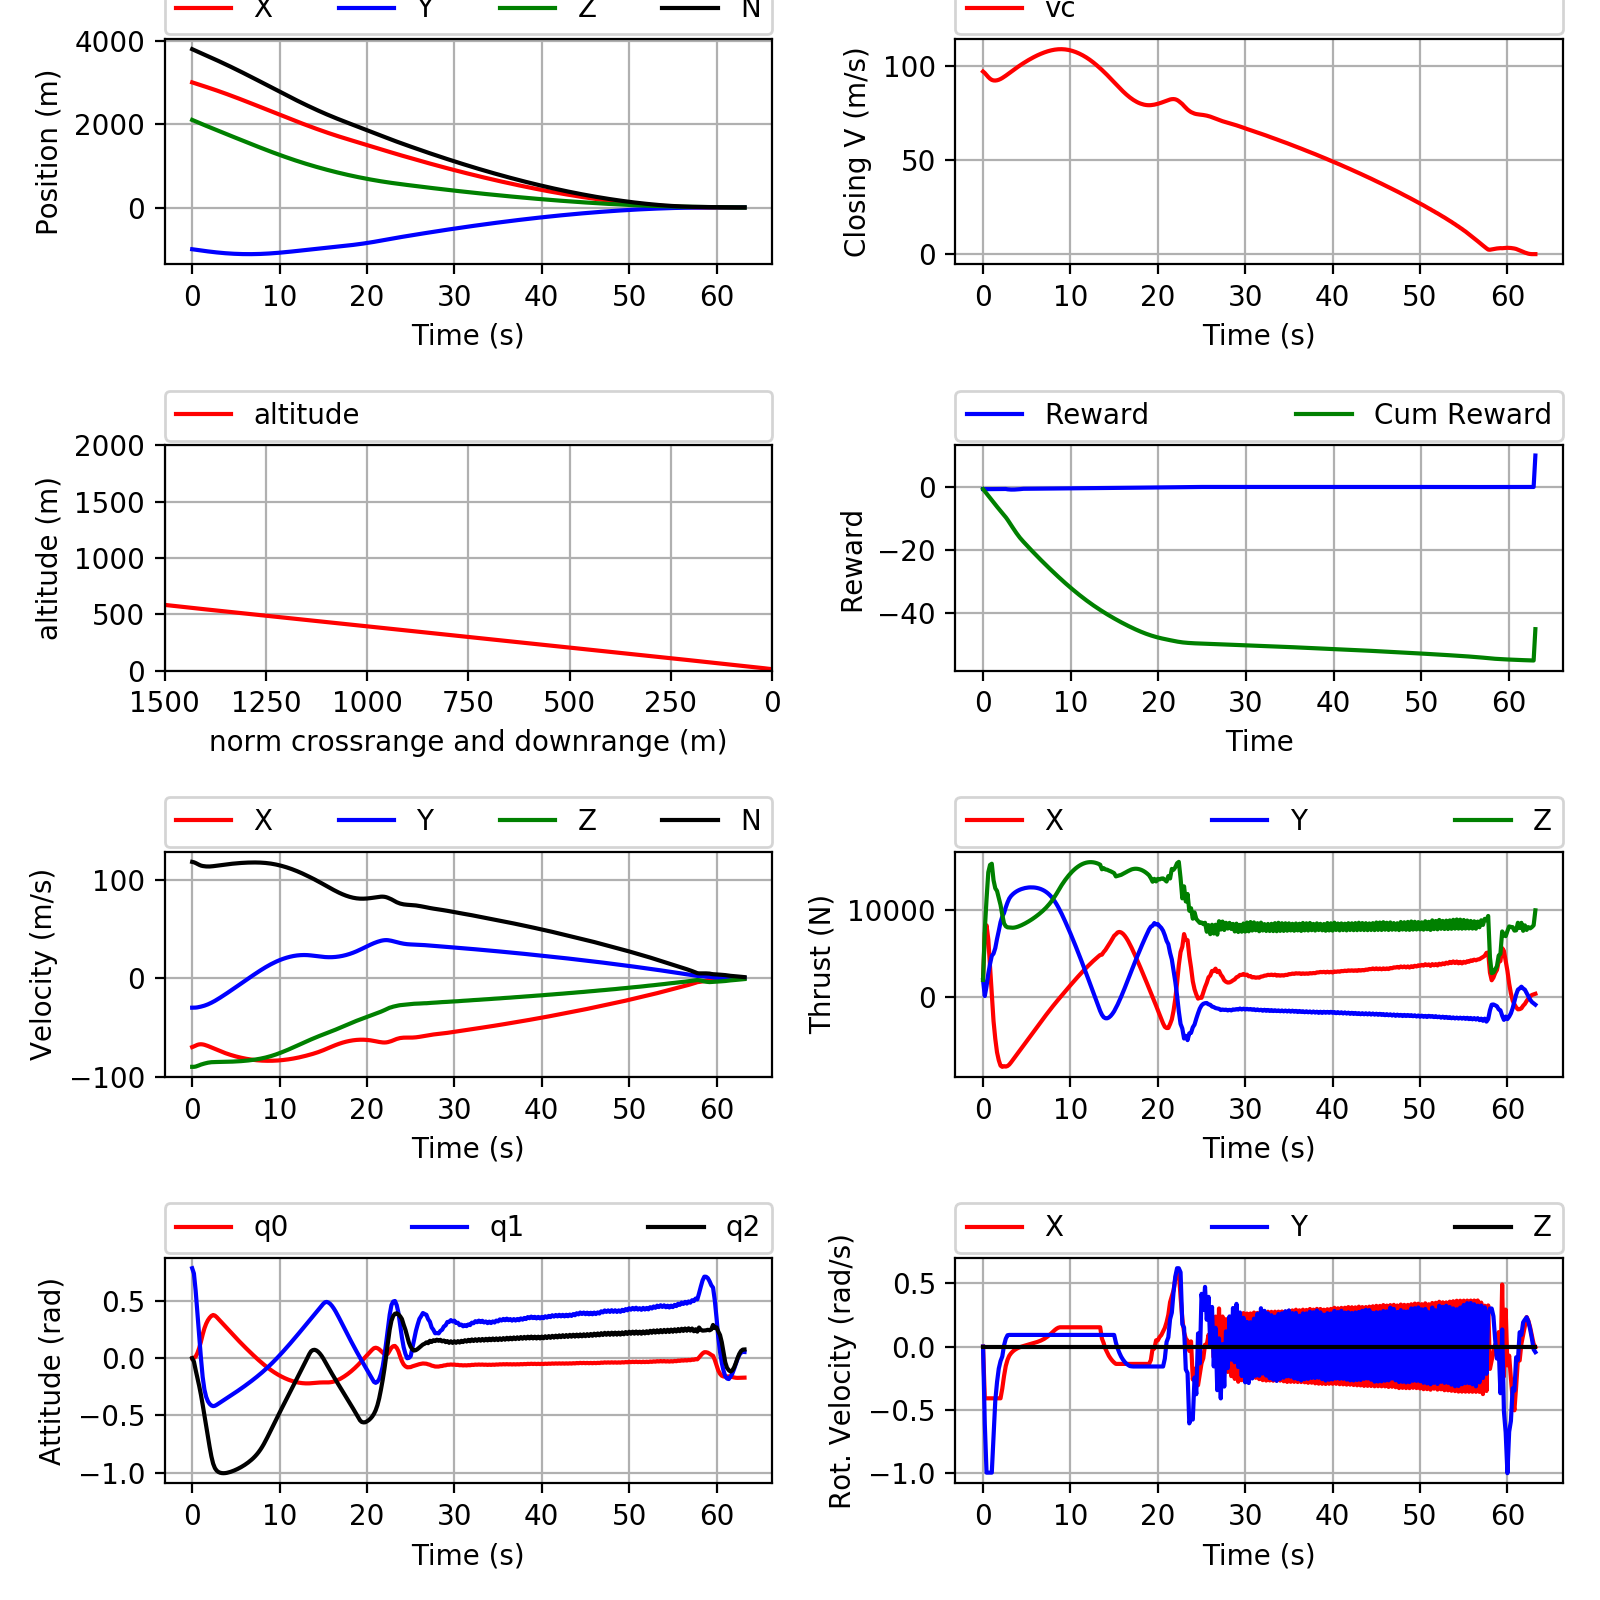

In [33]:
policy.test_mode=True
env.lander.apf_pot = env.lander.apf_pot2
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           attitude_parameterization=attitude_parameterization,
                           adapt_apf_v0=True,
                           downrange = (3000,3000 , -70, -70), 
                           crossrange = (-1000,-1000 , -30,-30),  
                           altitude = (2100,2100,-90,-90),
                          noise_u=20*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,1,print_every=1)
envu.render_traj(env.lander.trajectory_list[0])

In [31]:
print(env.lander.apf_pot)

<bound method Lander_model.apf_pot_foo3 of <lander_model.Lander_model object at 0x130513668>>


In [26]:
policy.test_mode=True
env.glideslope_constraint.gs_limit=0.00
lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=10.)
lander_model.get_state_agent = lander_model.get_state_agent9
env.lander=lander_model
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           attitude_parameterization=attitude_parameterization,
                           adapt_apf_v0=True,
                           downrange = (500,2500 , -70, -10), 
                           crossrange = (-500,500 , -0,0),  
                           altitude = (1900,2100,-90,-70),
                          noise_u=20*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)
#envu.render_traj(lander_model.trajectory_list[0])

Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  10.0
 - apf_tau1:  20
 - apf_tau2:  250


AttributeError: 'Lander_model' object has no attribute 'get_state_agent9'

In [68]:
I = lander_model.nominal_inertia_tensor.copy()
print(I)
rot = np.random.uniform(low=np.pi/16,high=np.pi/16,size=3)
#rot=np.zeros(3)
C = attu.Euler3212DCM(rot)
I_new = C.dot(I).dot(C.T)
print(I_new)

[[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
[[2045.67228049  -44.79470043 -225.19816651]
 [ -44.79470043 2043.93398282  220.87104689]
 [-225.19816651  220.87104689 3110.39373668]]


In [26]:
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Euler_attitude()


lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70)
lander_model.apf_pot = lander_model.apf_pot2
reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, landing_rlimit=100, landing_vlimit=10,fuel_coeff=-0.05)

glideslope_constraint = Glideslope_constraint(gs_limit=0.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10)
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=100.0,print_every=10)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9657.62 |2840.75 |3200.00 |16000.00 |    76
glideslope | 2.020 | 1.236 | 0.950 |76.920 |    29
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.9     0.1    -0.0 |     0.2     0.4     0.0 |     0.3    -0.7    -0.0 |     1.3     1.0    -0.0
velocity |   0.063   0.038  -0.758 |   0.063   0.097   0.151 |  -0.037  -0.159  -1.068 |   0.272   0.315  -0.272
fuel     |284.95 | 12.66 |254.18 |318.12
attitude |  -0.081  -0.038  -0.003 |   0.131   0.037   0.033 |  -0.477  -0.121  -0.075 |   0.208   0.053   0.076
w        |  -0.011   0.145  -0.001 |   0.030   0.028   0.006 |  -0.074   0.037  -0.012 |   0.053   0.195   0.015
glideslope |   2.796 |   0.515 |   1.712 |   4.612
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9660.51 |2835.66 |3200.00 |16000.00 |    76
glideslope | 2.077 | 1.335 | 0.844 |76.920 |    29
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats

KeyboardInterrupt: 

In [71]:
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen3_old import Landing_icgen
from thruster_model import Thruster_model

dynamics_model = Dynamics_model()
lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70)

env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=100.0,print_every=10)


env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=0.0, debug=False,
                           yaw   = (-np.pi/32, np.pi/32, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/32, np.pi/4, -0.01, 0.01),
                           inertia_uncertainty_diag=0.0, 
                           inertia_uncertainty_offdiag=0.0,
                           roll  = (-np.pi/32, np.pi/32, -0.01, 0.01))


policy.test_mode=True
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

6dof dynamics model
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander max thrust:  15000
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  5.0
 - apf_tau1:  20
 - apf_tau2:  250
lander env att 2 fixed
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9681.35 |2813.38 |3200.00 |16000.00 |    12
glideslope | 2.072 | 1.289 | 0.652 |62.772 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |     0.4    -1.7    -0.1 |     2.1     0.9    -0.0
velocity |   0.185  -0.018  -0.887 |   0.209   0.260   0.227 |  -0.000  -0.522  -1.464 |   1.062   0.927  -0.324
fuel     |283.46 | 10.52 |255.06 |312.35
attitude |  -0.019  -0.053  -0.018 |   0.336   0.040   0.042 |  -0.755  -0.152  -0.116 |   0.693   0.036   0.139
w        |  -0.013   0.141   0.001 |   0.051   0.046   0.006 |  -0.100  -0.1

position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.5    -1.8    -0.1 |     2.5     1.3    -0.0
velocity |   0.170   0.022  -0.856 |   0.179   0.245   0.207 |  -0.019  -0.639  -1.604 |   1.062   0.987  -0.287
fuel     |283.84 | 11.41 |255.06 |325.78
attitude |  -0.067  -0.049  -0.011 |   0.323   0.038   0.042 |  -0.760  -0.175  -0.116 |   0.693   0.083   0.139
w        |  -0.007   0.140  -0.000 |   0.045   0.037   0.006 |  -0.153  -0.108  -0.010 |   0.232   0.241   0.010
glideslope |   2.416 |   0.506 |   1.182 |   3.838
i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9676.37 |2815.65 |3200.00 |16000.00 |    12
glideslope | 2.126 | 1.988 | 0.553 |472.776 |   524
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.5    -1.9    -0.1 |     2.5     1.3    -0.0
velocity |   0.168   0.016  -0.857 |   0.178   0.244   0.206 |  -0.026  -0.639  -1.612 |   1.062   0.98

i :  2200
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.48 |2812.60 |3200.00 |16000.00 |    12
glideslope | 2.149 | 2.260 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.5    -1.9    -0.1 |     2.5     1.3    -0.0
velocity |   0.165   0.016  -0.850 |   0.173   0.238   0.206 |  -0.026  -0.639  -1.700 |   1.151   1.078  -0.251
fuel     |283.75 | 11.16 |254.72 |325.78
attitude |  -0.061  -0.048  -0.011 |   0.318   0.038   0.042 |  -0.760  -0.178  -0.139 |   0.693   0.119   0.139
w        |  -0.008   0.140  -0.000 |   0.044   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.232   0.241   0.010
glideslope |   2.428 |   0.510 |   1.149 |   4.232
i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9674.03 |2811.60 |3200.00 |16000.00 |    12
glideslope | 2.147 | 2.256 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  3300
Cumulative Stats (mean,std,max,argmax)
thrust   |9675.36 |2814.85 |3200.00 |16000.00 |    12
glideslope | 2.137 | 2.053 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -1.9    -0.1 |     2.5     1.3    -0.0
velocity |   0.165   0.017  -0.850 |   0.173   0.240   0.203 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.251
fuel     |283.89 | 11.28 |252.79 |325.78
attitude |  -0.061  -0.048  -0.010 |   0.319   0.038   0.042 |  -0.771  -0.178  -0.145 |   0.719   0.119   0.139
w        |  -0.008   0.141  -0.000 |   0.044   0.038   0.006 |  -0.153  -0.134  -0.010 |   0.273   0.277   0.010
glideslope |   2.428 |   0.512 |   1.149 |   4.291
i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.41 |2813.99 |3200.00 |16000.00 |    12
glideslope | 2.135 | 2.032 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  4400
Cumulative Stats (mean,std,max,argmax)
thrust   |9679.16 |2816.71 |3200.00 |16000.00 |  3879
glideslope | 2.130 | 1.960 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -1.9    -0.1 |     2.5     1.4    -0.0
velocity |   0.162   0.015  -0.849 |   0.171   0.239   0.202 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.251
fuel     |283.98 | 11.21 |252.18 |325.78
attitude |  -0.058  -0.048  -0.010 |   0.317   0.038   0.042 |  -0.771  -0.178  -0.155 |   0.719   0.119   0.144
w        |  -0.009   0.142   0.000 |   0.043   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.273   0.277   0.010
glideslope |   2.435 |   0.511 |   1.119 |   4.291
i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9678.46 |2816.81 |3200.00 |16000.00 |  3879
glideslope | 2.128 | 1.987 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  5500
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.67 |2815.65 |3200.00 |16000.00 |  3879
glideslope | 2.127 | 1.964 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -1.9    -0.1 |     2.5     1.4    -0.0
velocity |   0.162   0.015  -0.849 |   0.170   0.240   0.202 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.234
fuel     |283.97 | 11.19 |252.18 |325.78
attitude |  -0.057  -0.048  -0.010 |   0.318   0.038   0.042 |  -0.830  -0.178  -0.155 |   0.719   0.119   0.144
w        |  -0.009   0.142   0.000 |   0.043   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.285   0.277   0.010
glideslope |   2.439 |   0.517 |   1.119 |   6.114
i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.39 |2815.07 |3200.00 |16000.00 |  3879
glideslope | 2.129 | 1.954 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  6600
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.99 |2815.72 |3200.00 |16000.00 |  3879
glideslope | 2.126 | 2.376 | 0.534 |1643.406 |  5645
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -2.9    -0.1 |     2.5     1.4    -0.0
velocity |   0.163   0.017  -0.849 |   0.170   0.242   0.202 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.234
fuel     |283.95 | 11.27 |251.67 |325.78
attitude |  -0.059  -0.048  -0.010 |   0.318   0.038   0.042 |  -0.830  -0.210  -0.155 |   0.719   0.119   0.151
w        |  -0.009   0.142   0.000 |   0.044   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.285   0.277   0.010
glideslope |   2.433 |   0.516 |   1.119 |   6.114
i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.55 |2815.81 |3200.00 |16000.00 |  3879
glideslope | 2.124 | 2.364 | 0.534 |1643.406 |  5645
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

KeyboardInterrupt: 